## Grammatical Evolution

### Imports and setup

In [1]:
from parse_circuit import parse_circuit
import os
import warnings
from os import path

# Suppress warnings for cleaner outputs
warnings.filterwarnings("ignore")

# Path to data directory
DATA_PATH = "./grape"

# Set the working directory
os.chdir(DATA_PATH)

import grape  # Grammatical evolution library

# Path to grammar file
GRAMMAR_FILE = "grover.bnf"
BNF_GRAMMAR_PATH = path.join("grammars", GRAMMAR_FILE)
BNF_GRAMMAR = grape.Grammar(BNF_GRAMMAR_PATH)
import algorithms  # Evolutionary algorithms
from qiskit import QuantumCircuit, transpile  # Core Qiskit imports
from qiskit_aer import QasmSimulator  # Simulator
from qiskit.visualization import plot_histogram  # Plotting results
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from deap import creator, base, tools  # Genetic Algorithm tools

### Fitness Function

In [2]:
def fitness_function(individual, context=None):
    """
    Evaluates the fitness of a Grover's algorithm circuit.

    - Runs the quantum circuit on a simulator.
    - Measures the probability of obtaining the correct marked state.
    - Penalizes circuits with excessive gates.
    
    Returns: A tuple containing the fitness score.
    """
    # Define the correct marked state (update based on the problem instance)
    known_marked_state = "101"  # Example: Address `10` flips qubit 2

    
    try:
        # Decode the GE individual to generate a circuit string
        circuit_str = "".join(map(str, individual))

        # Parse the string into a Qiskit QuantumCircuit object
        qc = parse_circuit(circuit_str)

        # Ensure we have a 3-qubit circuit
        if qc.num_qubits != 3:
            return (0.0,)  # Invalid circuit, assign lowest fitness

        # Transpile for simulation efficiency
        simulator = QasmSimulator()
        compiled_circuit = transpile(qc, simulator)

        # Execute the circuit
        job = simulator.run(compiled_circuit, shots=1024)
        result = job.result()
        counts = result.get_counts()

        # Measure the probability of the correct marked state
        success_probability = counts.get(known_marked_state, 0) / 1024  # Normalize

        # Compute a penalty for excessive gate usage
        gate_penalty = qc.depth() / 100.0  # Normalize depth impact

        # Final fitness score (higher is better)
        fitness = success_probability - gate_penalty

        return (fitness,)

    except Exception as e:
        print(f"Error in fitness evaluation: {e}")
        return (0.0,)  # Invalid circuits get lowest fitness

In [3]:
POPULATION_SIZE = 100  
MAX_GENERATIONS = 100  
P_CROSSOVER = 0.45     
P_MUTATION = 0.45      
ELITE_SIZE = 1         
HALLOFFAME_SIZE = 1    
CODON_SIZE = 400       
MAX_TREE_DEPTH = 100   
TOURNAMENT_SIZE = 5   

In [4]:
# Create fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

# Initialize toolbox
toolbox = base.Toolbox()
toolbox.register(
    "populationCreator",
    grape.sensible_initialisation,
    creator.Individual,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=20,  
    max_init_depth=20,  # Reduce max tree depth
    codon_size=255,
    codon_consumption="lazy",
    genome_representation="list"
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)
toolbox.register("evaluate", fitness_function)


In [5]:
population = toolbox.populationCreator(pop_size=POPULATION_SIZE)
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# Prepare statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Run the GE evolutionary algorithm with elitism
population, logbook = algorithms.ge_eaSimpleWithElitism(
    population,
    toolbox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    elite_size=ELITE_SIZE,
    bnf_grammar=BNF_GRAMMAR,
    codon_size=400,
    max_tree_depth=50,
    max_genome_length=None,
    codon_consumption="lazy",
    report_items=["gen", "min", "max", "avg", "std"],
    genome_representation="list",
    stats=stats,
    halloffame=hof,
    verbose=True
)

Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluation: 'Individual' object is not iterable
Error in fitness evaluati

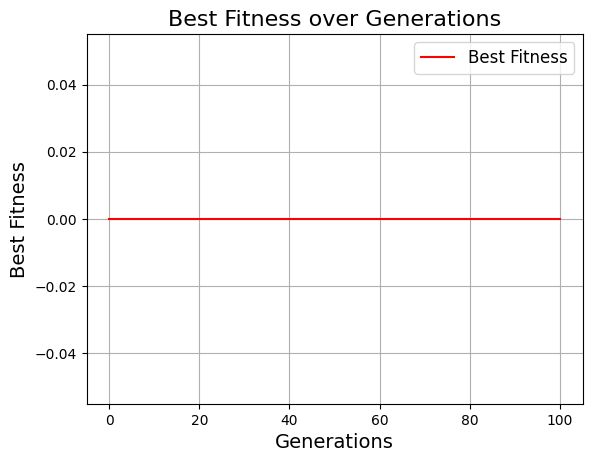

In [6]:
# Extract generations and minimum fitness values
generations = logbook.select("gen")
min_fitness_values = logbook.select("min")

# Plot best fitness over generations
plt.plot(generations, min_fitness_values, color='red', label="Best Fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.grid(True)
plt.show()